# Weak lensing – Notebook 25th January 2024 to ...

In [1]:
%matplotlib inline

import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from scipy import ndimage, signal, stats, optimize

import astropy as ap
from lenspack.utils import bin2d
from lenspack.image.inversion import ks93, ks93inv

In [2]:
with open('../config.yml', 'r') as file:
    config_data = yaml.safe_load(file)

KTNG_DIR = os.path.expanduser(config_data['ktng_dir'])
TRECS_DIR = os.path.expanduser(config_data['trecs_dir'])
TRECS_FILE = config_data['trec_file']

REDSHIFTS = [0.506, 1.034, 1.532] # red shifts for the simulated convergence maps
FILENAMES = ['kappa13', 'kappa23', 'kappa30'] # corresponding filenames

In [3]:
width_ori = 1024  # size of the simulated convergence maps (nb pixels)
width = 360 # size of the target convergence maps (nb pixels)
size_ori = 5.0  # opening angle of the simulated convergence maps (deg)
size = size_ori * width / width_ori # opening angle of the target convergence maps (deg)

resolution = size / width * 60. # arcmin/pixel
print(f"Resolution = {resolution:.2f} arcmin/pixel")

Resolution = 0.29 arcmin/pixel


## 2024-01-25 & 26

### Generate calibration and test sets from kappaTNG

In [4]:
index_redshift = 2

bin_file = f"{FILENAMES[index_redshift]}.dat"
png_file = f"{FILENAMES[index_redshift]}.png"

redshift = REDSHIFTS[index_redshift]

In [5]:
ninpimgs = 50
list_of_idx = np.arange(ninpimgs) + 1
vectorized_zfill = np.vectorize(lambda x: str(x).zfill(3))
list_of_idx = vectorized_zfill(list_of_idx)

n_samples_per_side = 3

In [6]:
def split_map(kappa, n_samples_per_side):

    step = (width_ori - width) // (n_samples_per_side - 1)
    out = []
    beg_i = 0
    for i in range(n_samples_per_side):
        beg_j = 0
        for j in range(n_samples_per_side):
            subkappa = kappa[beg_i:beg_i+width, beg_j:beg_j+width]
            subkappa = subkappa - np.mean(subkappa) # Center-normalize the convergence map
            out.append(subkappa)
            beg_j += step
        beg_i += step

    return out

In [7]:
list_of_kappa = []
vmin = np.inf
vmax = -np.inf
for idx in list_of_idx:
    fname = os.path.join(KTNG_DIR, f"run{idx}", bin_file)
    with open(fname, 'rb') as f:
        dummy = np.fromfile(f, dtype="int32", count=1)
        kappa = np.fromfile(f, dtype="float", count=width_ori*width_ori)
        dummy = np.fromfile(f, dtype="int32", count=1)
    kappa = kappa.reshape((width_ori, width_ori))
    fname_png = os.path.join(KTNG_DIR, f"run{idx}", png_file)
    list_of_kappa += split_map(kappa, n_samples_per_side)
    vmin = min(vmin, np.min(kappa))
    vmax = max(vmax, np.max(kappa))

kappa = np.stack(list_of_kappa)
np.random.shuffle(kappa)
nimgs = kappa.shape[0]

Create shear maps from the convergence maps:

In [8]:
vectorized_ks93 = np.vectorize(ks93, signature='(n,m),(n,m)->(n,m),(n,m)')
vectorized_ks93inv = np.vectorize(ks93inv, signature='(n,m),(n,m)->(n,m),(n,m)')

In [9]:
bmode = np.zeros((nimgs, width, width)) # no B-mode (convergence maps are real-valued)
gamma1, gamma2 = vectorized_ks93inv(kappa, bmode)
gamma2 = -gamma2 # use convention from jax_lensing (due to the inversion of the x-axis?)
vmax_gamma = max(
    np.max(gamma1), np.max(gamma2), -np.min(gamma1), -np.min(gamma2)
)

Randomly split the convergence maps into calibration and test sets:

In [10]:
nimgs_calib = 100
nimgs_test = nimgs - nimgs_calib

kappa_calib = kappa[:nimgs_calib]
gamma1_calib = gamma1[:nimgs_calib]
gamma2_calib = gamma2[:nimgs_calib]

kappa_test = kappa[nimgs_calib:]
gamma1_test = gamma1[nimgs_calib:]
gamma2_test = gamma2[nimgs_calib:]

del list_of_kappa

### Use data from the T-RECS catalog
*https://github.com/abonaldi/TRECS*

As for ShapeNet [1], we will use the dataset of star-forming galaxies (SFGs) from the T-RECS simulated catalog [2]. According to this paper, it "can be used for simulating observations and predicting results from deep radio surveys with existing and forthcoming radio facilities, such as SKA."

[1] F. Nammour et al., “ShapeNet: Shape constraint for galaxy image deconvolution,” Astronomy and Astrophysics, vol. 663, p. A69, Jul. 2022.

[2] A. Bonaldi et al., “The Tiered Radio Extragalactic Continuum Simulation (T-RECS),” Monthly Notices of the Royal Astronomical Society, vol. 482, no. 1, pp. 2–19, Jan. 2019.

#### Get statistics from the COSMOS catalog

In [11]:
%store -r ra_cosmos_mean dec_cosmos_mean extent

#### Open T-RECS catalogue

The dataset can be dowloaded from this [ftp server](http://cdsarc.u-strasbg.fr/ftp/VII/282/fits/).

In [12]:
catalog_sfg = ap.io.fits.open(os.path.join(TRECS_DIR, TRECS_FILE))
catdata_sfg = catalog_sfg[1].data
catalog_sfg.info()

Filename: /home/leterme231/Documents/Data/T-RECS/catalogue_SFGs_complete_medium.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  Catalogue     1 BinTableHDU    197   28263241R x 47C   ['1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E', '1E']   


Discard objects that are larger than 10 pixels and smaller than 70 pixels on the sky:

Filter by redshift:

In [13]:
# From A. Bonaldi et al., “The Tiered Radio Extragalactic Continuum Simulation (T-RECS),”
# Monthly Notices of the Royal Astronomical Society, vol. 482, no. 1, pp. 2–19, Jan. 2019.
min_redshift = 0.
max_redshift = 8.
#n_snapshots = 201 # as in the original simulation, but the bins are too small (not enough galaxies per pixel)
n_snapshots = 21
bins_redshift = np.linspace(min_redshift, max_redshift, n_snapshots)

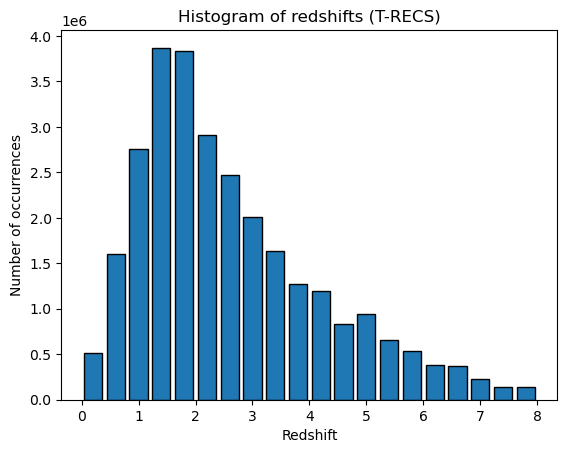

In [14]:
redshifts = catdata_sfg["redshift"]

plt.hist(
    redshifts, bins=bins_redshift, align='mid', edgecolor='black', rwidth=0.8
)
plt.xlabel('Redshift')
plt.ylabel('Number of occurrences')
plt.title('Histogram of redshifts (T-RECS)')
plt.show()

In [15]:
binindex = np.digitize(redshift, bins_redshift) - 1

filter_redshift = np.logical_and(
    redshifts >= bins_redshift[binindex],
    redshifts < bins_redshift[binindex+1]
)
catdata_sfg = catdata_sfg[filter_redshift]

print(f"Redshift interval = [{bins_redshift[binindex]:.2f}, {bins_redshift[binindex+1]:.2f}]")

Redshift interval = [1.20, 1.60]


Get sizes, coordinates, ellipticities, and redshifts:

In [16]:
size_sfg = catdata_sfg['size']

# Coordinates (in degree)
ra_sfg = catdata_sfg['longitude'].copy()
dec_sfg = catdata_sfg['latitude'].copy()

# Rotate the coordinates to get the same extent as the COSMOS catalog
ra_sfg = (ra_sfg + ra_cosmos_mean) % 360
dec_sfg = (dec_sfg + dec_cosmos_mean) % 360

# Ellipticities
e1_sfg = catdata_sfg['e1']
e2_sfg = catdata_sfg['e2']

Create a map of number of galaxies per pixel:

In [17]:
def shift_coords(coord, mean_coord):
    min_coord = mean_coord - 180
    return (coord - min_coord) % 360 + min_coord

In [18]:
ra_sfg_shifted = shift_coords(ra_sfg, ra_cosmos_mean)
dec_sfg_shifted = shift_coords(dec_sfg, dec_cosmos_mean)

n_gal_map_sfg = bin2d(
    ra_sfg_shifted, dec_sfg_shifted, npix=width,
    extent=extent
)

print(f"Number of selected galaxies within the boundaries = {np.sum(n_gal_map_sfg):.0f}")

Number of selected galaxies within the boundaries = 481498


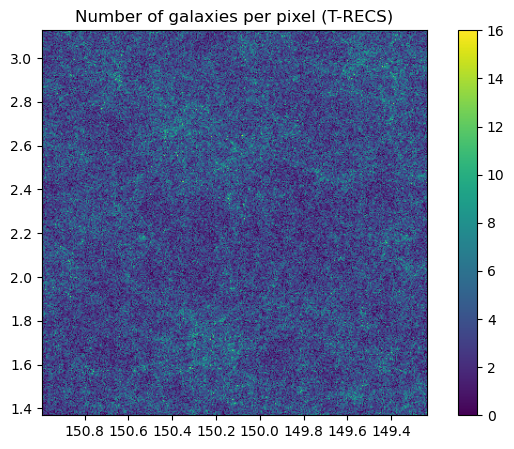

In [19]:
plt.figure(figsize=(8, 5))
plt.imshow(
    n_gal_map_sfg, origin='lower',
    extent=extent
)
plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
plt.colorbar()
plt.title("Number of galaxies per pixel (T-RECS)")
plt.show()

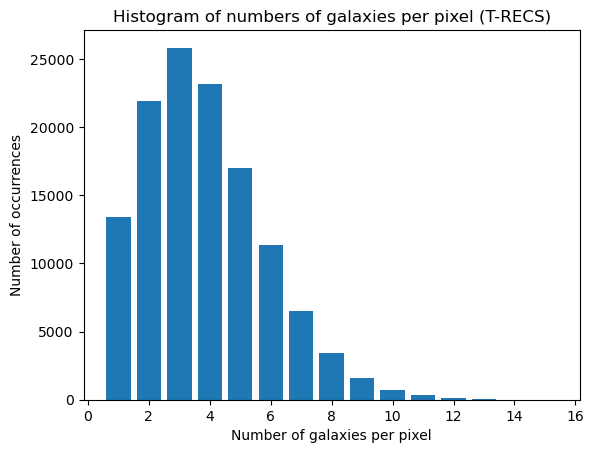

In [20]:
plt.hist(
    n_gal_map_sfg.flatten(), bins=np.arange(1, n_gal_map_sfg.max() + 1) - 0.5,
    align='mid', rwidth=0.8
)
plt.xlabel('Number of galaxies per pixel')
plt.ylabel('Number of occurrences')
plt.title('Histogram of numbers of galaxies per pixel (T-RECS)')
plt.show()

Create binary mask for empty pixels:

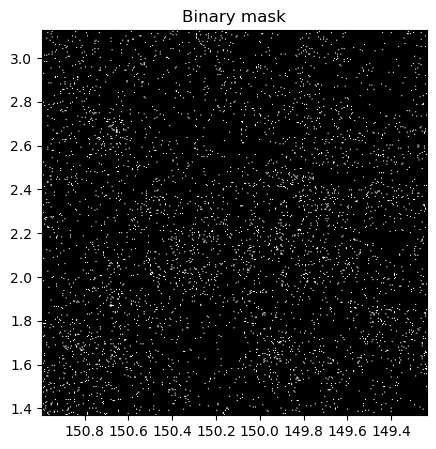

In [21]:
plt.figure(figsize=(5, 5))
mask_sfg = (n_gal_map_sfg == 0)
plt.imshow(mask_sfg, cmap='gray', origin='lower', extent=extent)
plt.xlim(plt.gca().get_xlim()[::-1])
plt.title("Binary mask")
plt.show()

Estimate shape dispersion of galaxies:

In [22]:
shapedisp1_sfg = np.std(e1_sfg)
shapedisp2_sfg = np.std(e2_sfg)

print(f"Shape dispersion 1 = {shapedisp1_sfg:.3f}")
print(f"Shape dispersion 2 = {shapedisp2_sfg:.3f}")

Shape dispersion 1 = 0.252
Shape dispersion 2 = 0.252


#### Add noise and mask from the T-RECS catalog

In [23]:
# For masked data, we set in practice a variance which is on the same order of magnitude as the
# maximum values of the simulated convergence maps.
multfact_maxval = 0.8
maxval = np.max(kappa_test)
posinf = multfact_maxval * maxval

shapedisp_sfg = (shapedisp1_sfg + shapedisp2_sfg) / 2
std_sfg = np.nan_to_num(
    shapedisp_sfg / np.sqrt(n_gal_map_sfg), posinf=posinf
)

/tmp/ipykernel_9616/2909290925.py:9: RuntimeWarning: divide by zero encountered in divide
  shapedisp_sfg / np.sqrt(n_gal_map_sfg), posinf=posinf


In [24]:
# Set masked values to 0
gamma1_masked_sfg_test = (1 - mask_sfg) * gamma1_test
gamma2_masked_sfg_test = (1 - mask_sfg) * gamma2_test
gamma1_masked_sfg_calib = (1 - mask_sfg) * gamma1_calib
gamma2_masked_sfg_calib = (1 - mask_sfg) * gamma2_calib

# Add noise to the shear maps
gamma1_noisy_sfg_test = gamma1_masked_sfg_test + std_sfg * np.random.randn(nimgs_test, width, width)
gamma2_noisy_sfg_test = gamma2_masked_sfg_test + std_sfg * np.random.randn(nimgs_test, width, width)
gamma1_noisy_sfg_calib = gamma1_masked_sfg_calib + std_sfg * np.random.randn(nimgs_calib, width, width)
gamma2_noisy_sfg_calib = gamma2_masked_sfg_calib + std_sfg * np.random.randn(nimgs_calib, width, width)

In [26]:
nexamples = 2
saturation = 0.6
rand_idx = np.random.randint(nimgs_test, size=nexamples)

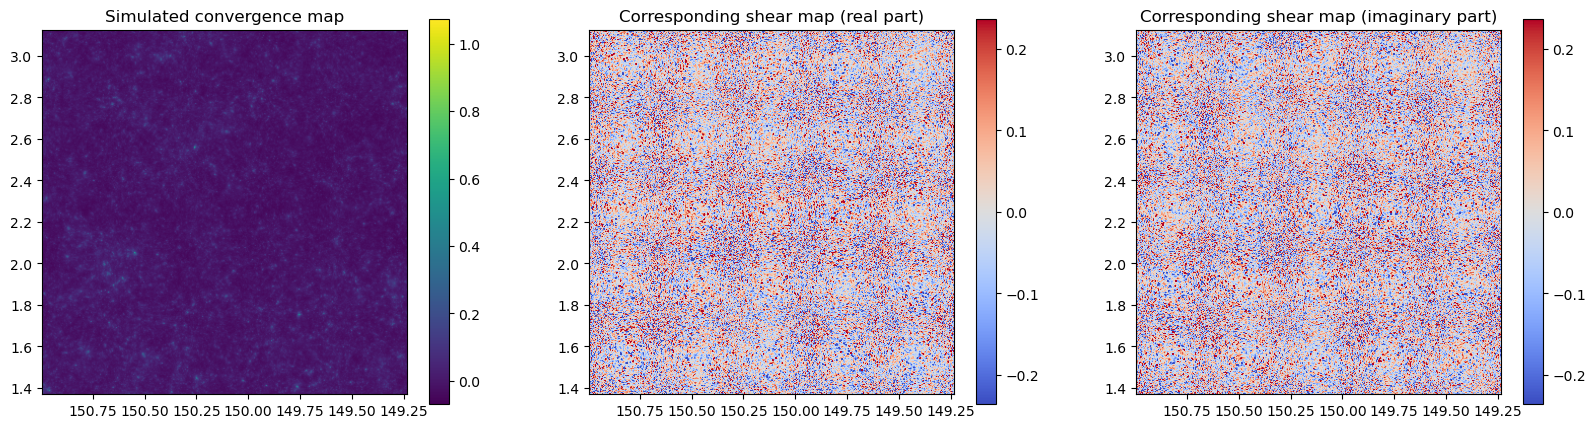

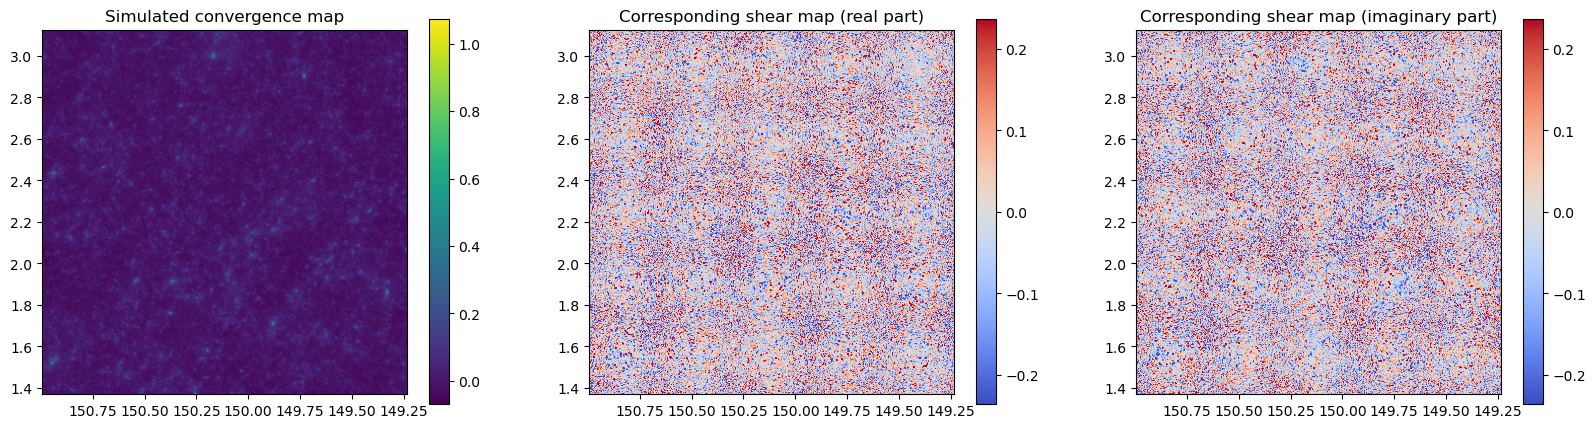

In [27]:
for i, idx in enumerate(rand_idx):
    kappa = kappa_test[idx]
    gamma1, gamma2 = gamma1_noisy_sfg_test[idx], gamma2_noisy_sfg_test[idx]

    plt.figure(figsize=(20, 5))

    plt.subplot(131)
    plt.imshow(kappa, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
    plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
    plt.colorbar()
    plt.title("Simulated convergence map")

    plt.subplot(132)
    plt.imshow(
        gamma1, cmap='coolwarm', origin='lower',
        vmin=-saturation*vmax_gamma, vmax=saturation*vmax_gamma, extent=extent
    )
    plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
    plt.colorbar()
    plt.title("Corresponding shear map (real part)")

    plt.subplot(133)
    plt.imshow(
        gamma2, cmap='coolwarm', origin='lower',
        vmin=-saturation*vmax_gamma, vmax=saturation*vmax_gamma, extent=extent
    )
    plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
    plt.colorbar()
    plt.title("Corresponding shear map (imaginary part)")

    plt.show()

#### Apply the KS filter to the noisy shear maps

In [29]:
std_gaussianfilter = 2.

kappa_ks_sfg_test, _ = vectorized_ks93(gamma1_noisy_sfg_test, -gamma2_noisy_sfg_test)
kappa_ks_sfg_smoothed_test = ndimage.gaussian_filter(
    kappa_ks_sfg_test, std_gaussianfilter, mode="wrap", axes=(1, 2)
)

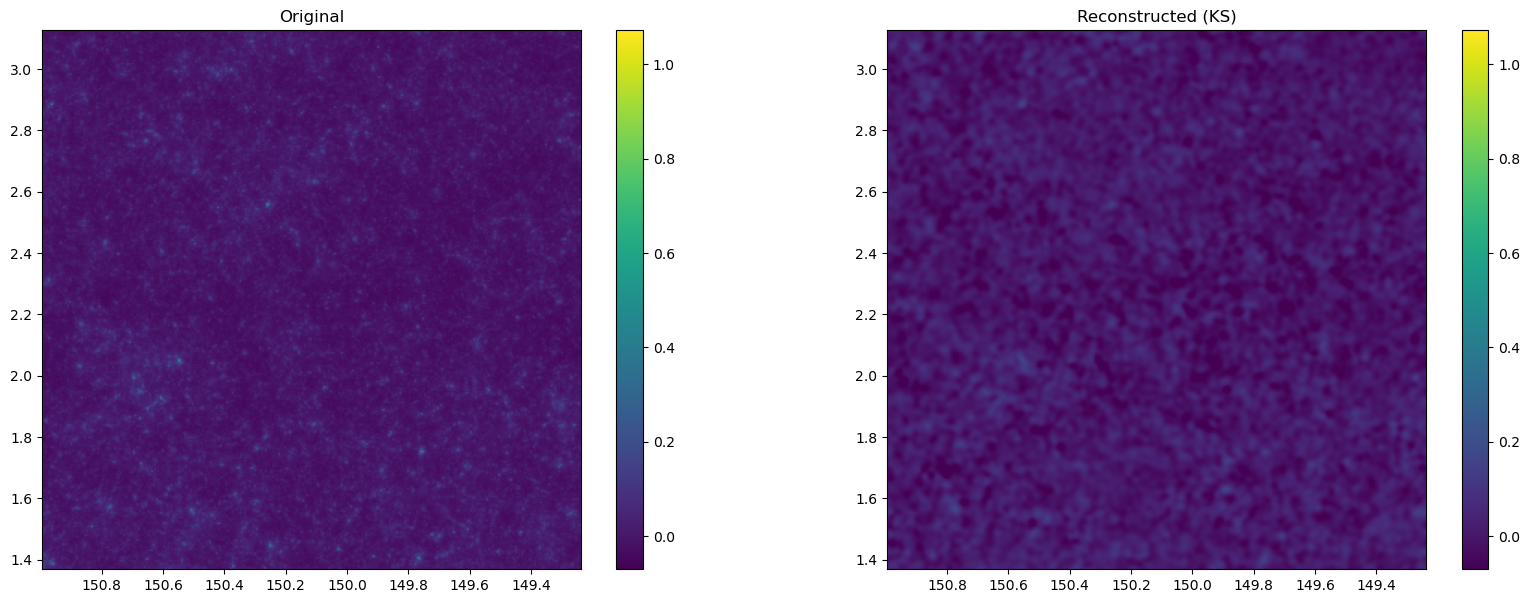

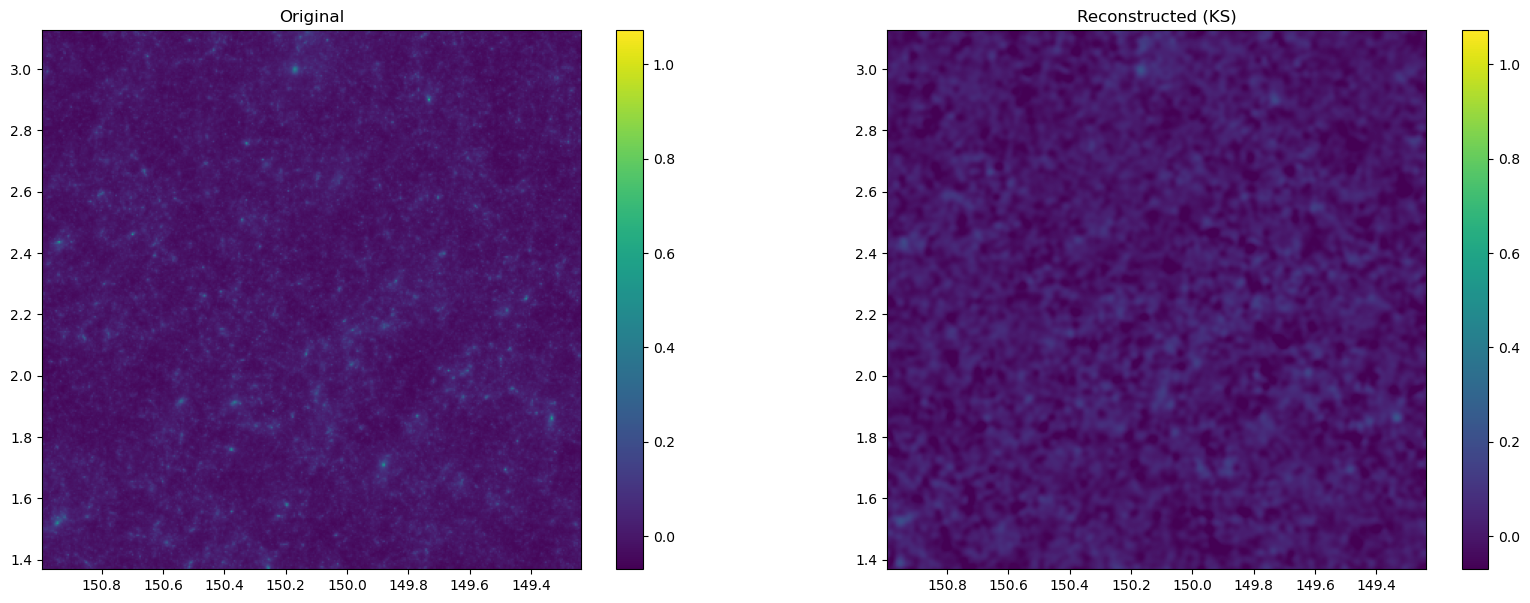

In [30]:
for i, idx in enumerate(rand_idx):
    kappa_ori = kappa_test[idx] # original
    kappa_ks = kappa_ks_sfg_test[idx]
    kappa_ks_smoothed = kappa_ks_sfg_smoothed_test[idx] # reconstructed

    plt.figure(figsize=(20, 7))

    plt.subplot(121)
    plt.imshow(kappa_ori, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
    plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis
    plt.colorbar()
    plt.title("Original")

    plt.subplot(122)
    plt.imshow(kappa_ks_smoothed, origin='lower', vmin=vmin, vmax=vmax, extent=extent)
    plt.xlim(plt.gca().get_xlim()[::-1]) # Flip x-axis  
    plt.colorbar()
    plt.title("Reconstructed (KS)")

    plt.show()